## Loading data and defining functions

In [ ]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as jnp

import pylab as plt
import imageio
import os
import numpy as np
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from skimage import exposure
import pandas as pd

In [ ]:
from jax.lib import xla_bridge
# Check if ultilising GPU
print(xla_bridge.get_backend().platform)

# If on CPU do the following:
# pip install --upgrade "jax[cuda]"
# change runtime to GPU 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_csv  = "/content/drive/MyDrive/DSA4212/Dataset/celeba.csv"
attribute = pd.read_csv(path_csv)

In [ ]:
#let us list all the files in the image directory
#path = "/Users/alex/Dataset/DSA4212_dataset/img_celeba_small/"
path = "/content/drive/MyDrive/DSA4212/Dataset/img_celeba_small/"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


In [ ]:
def preprocessing(n_img,pixel_value,contrast = False):
    img_array = np.zeros((n_img*2, pixel_value, pixel_value))

    for k in range(n_img):
        im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
        #im = im[30:]  # removing top of image
        im = im[20:]
        im = im[0:-20]
        im = np.delete(im, slice(0,20), 1)
        im = np.delete(im, slice(138,158), 1)
        im = resize(im, (pixel_value,pixel_value) )
        im = np.mean(im, axis=2) # average the last channel
        if contrast == True:
            im = exposure.rescale_intensity(im)*255
        img_array[k*2,:,:] = im
        #im = np.fliplr(im) # mirror image
        #img_array[k*2+1,:,:] = im

    test_n_img = 5000
    test_img_array = np.zeros((test_n_img, pixel_value, pixel_value))

    for k in range(test_n_img):
        im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
        im = im[20:]
        im = im[0:-20]
        im = np.delete(im, slice(0,20), 1)
        im = np.delete(im, slice(138,158), 1)
        im = resize(im, (pixel_value,pixel_value) )
        im = np.mean(im, axis=2) # average the last channel
        if contrast == True:
            im = exposure.rescale_intensity(im)*255
        test_img_array[k,:,:] = im

    X_train = img_array[0:n_img].reshape(n_img,pixel_value*pixel_value)/255 # we need to choose from 2x the image set size
    Y_train = jnp.array(attribute["Male"][0:n_img])
    #Y_train = jnp.append(Y_train, Y_train)
    X_test = test_img_array.reshape(test_n_img,pixel_value*pixel_value)/255
    Y_test = jnp.array(attribute["Male"][15000:20000])
    # parameter of the logistic regression
    # let us generate it at random
    return X_train,Y_train,X_test,Y_test

def preprocessing_RGB(n_img,pixel_value):
    img_array = np.zeros((n_img*2, pixel_value*3*pixel_value))

    for k in range(n_img):
        im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
        im = im[30:]  # removing top of image
        im = resize(im, (pixel_value,pixel_value) )
        im_mirror = np.fliplr(im)
        im = im.flatten()
        img_array[k*2,:] = im
        im_mirror = im_mirror.flatten()
        img_array[k*2+1,:] = im_mirror

    test_n_img = 5000
    test_img_array = np.zeros((test_n_img, pixel_value*3*pixel_value))

    for k in range(test_n_img):
        im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
        im = im[30:]  # removing top of image
        im = resize(im, (pixel_value,pixel_value) )
        im = im.flatten()
        test_img_array[k,:] = im

    X_train = img_array[0:n_img]/255
    Y_train = jnp.array(attribute["Male"][0:n_img])
    X_test = test_img_array/255
    Y_test = jnp.array(attribute["Male"][15000:20000])
        # parameter of the logistic regression
    # let us generate it at random
    return X_train,Y_train,X_test,Y_test

def preprocessing_facepart(n_img,pixel_value):
    hair_array = np.zeros((n_img*2, pixel_value, pixel_value))
    eyes_array = np.zeros((n_img*2, pixel_value, pixel_value))
    nose_array = np.zeros((n_img*2, pixel_value, pixel_value))
    jaw_array = np.zeros((n_img*2, pixel_value, pixel_value))

    for k in range(n_img):
        im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
        im = np.mean(im, axis=2)
        im = exposure.rescale_intensity(im)*255
        im = im[30:] # removing top of image

        im_hair = im[:60] # Cropping hair
        im_hair = resize(im_hair, (pixel_value,pixel_value) )
        hair_array[k*2,:,:] = im_hair
        im_hair_mir = np.fliplr(im_hair) # mirror image
        hair_array[k*2+1,:,:] = im_hair_mir

        im_eyes = im[60:95] # Cropping eye
        im_eyes = resize(im_eyes, (pixel_value,pixel_value) )
        eyes_array[k*2,:,:] = im_eyes
        im_eyes_mir = np.fliplr(im_eyes) # mirror image
        eyes_array[k*2+1,:,:] = im_eyes_mir


        im_nose = im[95:115] # Cropping nose
        im_nose = resize(im_nose, (pixel_value,pixel_value) )
        nose_array[k*2,:,:] = im_nose
        im_nose_mir = np.fliplr(im_nose) # mirror image
        nose_array[k*2+1,:,:] = im_nose_mir

        im_jaw = im[115:165] # Cropping jaw
        im_jaw = resize(im_jaw, (pixel_value,pixel_value) )
        jaw_array[k*2,:,:] = im_jaw
        im_jaw_mir = np.fliplr(im_jaw) # mirror image
        jaw_array[k*2+1,:,:] = im_jaw_mir

    test_n_img = 5000
    test_hair_array = np.zeros((test_n_img, pixel_value, pixel_value))
    test_eyes_array = np.zeros((test_n_img, pixel_value, pixel_value))
    test_nose_array = np.zeros((test_n_img, pixel_value, pixel_value))
    test_jaw_array = np.zeros((test_n_img, pixel_value, pixel_value))

    for k in range(test_n_img):
        im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
        im = np.mean(im, axis=2)
        im = exposure.rescale_intensity(im)*255
        im = im[30:] # removing top of image

        im_hair = im[:60] # Cropping hair
        im_hair = resize(im_hair, (pixel_value,pixel_value) )
        test_hair_array[k,:,:] = im_hair


        im_eyes = im[60:95] # Cropping eye
        im_eyes = resize(im_eyes, (pixel_value,pixel_value) )
        test_eyes_array[k,:,:] = im_eyes


        im_nose = im[95:115] # Cropping nose
        im_nose = resize(im_nose, (pixel_value,pixel_value) )
        test_nose_array[k,:,:] = im_nose

        im_jaw = im[115:165] # Cropping jaw
        im_jaw = resize(im_jaw, (pixel_value,pixel_value) )
        test_jaw_array[k,:,:] = im_jaw

    X_train_hair = hair_array[0:n_img].reshape(n_img,pixel_value*pixel_value)/255
    X_train_eyes = eyes_array[0:n_img].reshape(n_img,pixel_value*pixel_value)/255
    X_train_nose = nose_array[0:n_img].reshape(n_img,pixel_value*pixel_value)/255
    X_train_jaw = jaw_array[0:n_img].reshape(n_img,pixel_value*pixel_value)/255
    Y_train = jnp.array(attribute["Male"][0:n_img])

    X_test_hair = test_hair_array.reshape(test_n_img,pixel_value*pixel_value)/255
    X_test_eyes = test_eyes_array.reshape(test_n_img,pixel_value*pixel_value)/255
    X_test_nose = test_nose_array.reshape(test_n_img,pixel_value*pixel_value)/255
    X_test_jaw = test_jaw_array.reshape(test_n_img,pixel_value*pixel_value)/255
    Y_test = jnp.array(attribute["Male"][15000:20000])
    
    return X_train_hair,X_train_eyes,X_train_nose,X_train_jaw,Y_train,X_test_hair,X_test_eyes,X_test_nose,X_test_jaw,Y_test

In [ ]:
X_train,Y_train,X_test,Y_test = preprocessing(1000,100)

In [ ]:
beta_standard_dev = 1. / 100.
beta_init = np.random.normal(0,beta_standard_dev,100*100)

In [ ]:
# let us now define a function that can compute the error rate
@jax.jit
def compute_error_rate(beta, X, Y):
    # compute predictions
    pred_bool = prediction_batch(beta, X) > 0.5
    
    # convert to +1/-1 predictions
    pred = 2*pred_bool - 1
    
    # return the error rate
    return jnp.mean(Y == pred)

def predict(beta, X):
    pred_bool = prediction_batch(beta, X) > 0.5
    
    # convert to +1/-1 predictions
    pred = 2*pred_bool - 1
    return pred

In [ ]:
def prediction(beta, x):
    """
    desc:
    =====
    compute the probability that x is associated to a +1 label

    args:
    ====
     x: vector of dimension 784
     beta: vector of dimension 784 (logistic reg param)     
    """
    proba = 1. / (1. + jnp.exp(-jnp.dot(x,beta)))
    return proba

# let us parallelize the function:
# beta: no parallelization
# x: parallelization along the axis 0
prediction_batch = jax.vmap(prediction, in_axes=(None, 0))

In [ ]:
def loss_single(beta, x, y):
    """ default loss function """
    return jnp.log(1. + jnp.exp(-y*jnp.dot(x,beta)))

def l1_loss_single(beta, x, y):
    lamb = 0.1
    return jnp.log(1. + jnp.exp(-y * jnp.dot(x,beta))) + lamb*jnp.linalg.norm(jnp.abs(beta),1)
    
def l2_loss_single(beta, x, y):
    lamb = 0.1
    return jnp.log(1. + jnp.exp(-y * jnp.dot(x,beta))) + lamb*jnp.linalg.norm(jnp.abs(beta),2)

loss_batch = jax.vmap(loss_single, in_axes=(None, 0, 0))
l1_loss_batch = jax.vmap(l1_loss_single, in_axes=(None, 0, 0))
l2_loss_batch = jax.vmap(l2_loss_single, in_axes=(None, 0, 0))
# let us test this
"""
x = X_train[0]
y = Y_train[0]
beta=beta_init
loss_single(beta, x, y)


"""

'\nx = X_train[0]\ny = Y_train[0]\nbeta=beta_init\nloss_single(beta, x, y)\n\n\n'

In [ ]:
@jax.jit
def loss_LR(beta, X, Y):
    """
    Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
    """
    # compute all the individual losses
    losses = loss_batch(beta, X, Y)
    return jnp.mean(losses)

def l1_loss_LR(beta, X, Y):
    """
    Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
    """
    # compute all the individual losses
    losses = l1_loss_batch(beta, X, Y)
    return jnp.mean(losses)
    
def l2_loss_LR(beta, X, Y):
    """
    Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
    """
    # compute all the individual losses
    losses = l2_loss_batch(beta, X, Y)
    return jnp.mean(losses)

# compute derivates
loss_LR_values_and_grad = jax.jit(jax.value_and_grad(loss_LR, argnums=0))
l1_loss_LR_values_and_grad = jax.jit(jax.value_and_grad(l1_loss_LR, argnums=0))
l2_loss_LR_values_and_grad = jax.jit(jax.value_and_grad(l2_loss_LR, argnums=0))

In [ ]:
def train_SGD(beta_init,X_train,Y_train,X_test,Y_test,learning_rate_init = 0.01, regularization = 0, minibatch_size = 20, n_epoch = 50):
    """
    desc:
    ===
    runs SGD with step decay
    
    returns:
    1) Loss at the end of each epoch
    2) Final validation accuracy
    3) Predictions with the given test set
    """

    N = len(X_train)  #10000, total number of images
    img_indices = np.arange(N)
    loss_history = []
    loss_history_end_epoch = []
    beta = np.copy(beta_init)
    learning_rate = learning_rate_init

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)
        
        # Step Decay
        if epoch % 5 == 0:
            learning_rate/=2
                    
        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = X_train[batch_indices]
            Y_minibatch = Y_train[batch_indices]

            # compute the stochastic gradient
            if regularization == 0:
                val, grad = loss_LR_values_and_grad(beta, X_minibatch, Y_minibatch)
            elif regularization == 1:
                val, grad = l1_loss_LR_values_and_grad(beta, X_minibatch, Y_minibatch)
            elif regularization == 2:
                val, grad = l2_loss_LR_values_and_grad(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad
            
            # book-keeping
            loss_history.append(val)
            all_loss_within_epoch.append(val)

        loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
        
        if epoch % 2 == 0:
            # let us compute the train/validation error rate
            err_train = 100*compute_error_rate(beta, X_train, Y_train)
            err_val= 100*compute_error_rate(beta, X_test, Y_test)        
            print(f"epoch:{epoch} \t Loss:{val:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")

    err_val= 100*compute_error_rate(beta, X_test, Y_test)
    prediction = predict(beta, X_test)
    return loss_history_end_epoch, err_val, prediction

## Varying Number of Training Samples

number of samples:  1000
epoch:0 	 Loss:0.772 	 error(train):44.2% 	 error(val):42.3%
epoch:2 	 Loss:0.825 	 error(train):56.8% 	 error(val):58.0%
epoch:4 	 Loss:0.454 	 error(train):57.0% 	 error(val):58.1%
epoch:6 	 Loss:0.705 	 error(train):51.4% 	 error(val):43.8%
epoch:8 	 Loss:0.594 	 error(train):65.9% 	 error(val):52.5%
epoch:10 	 Loss:0.730 	 error(train):66.4% 	 error(val):53.7%
epoch:12 	 Loss:0.621 	 error(train):62.0% 	 error(val):47.6%
epoch:14 	 Loss:0.610 	 error(train):64.7% 	 error(val):55.7%
epoch:16 	 Loss:0.628 	 error(train):66.9% 	 error(val):54.3%
epoch:18 	 Loss:0.531 	 error(train):65.2% 	 error(val):55.8%
epoch:20 	 Loss:0.512 	 error(train):65.9% 	 error(val):54.9%
epoch:22 	 Loss:0.649 	 error(train):69.2% 	 error(val):52.8%
epoch:24 	 Loss:0.598 	 error(train):67.9% 	 error(val):53.5%
epoch:26 	 Loss:0.558 	 error(train):68.1% 	 error(val):53.4%
epoch:28 	 Loss:0.601 	 error(train):69.0% 	 error(val):53.0%
epoch:30 	 Loss:0.575 	 error(train):67.8% 	 error

Text(0.5, 1.0, 'Number of Training Samples')

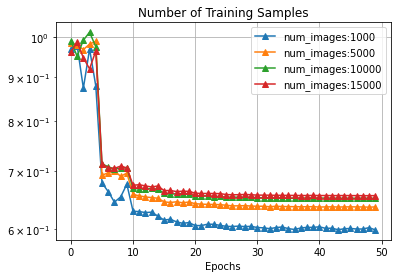

In [ ]:
lst = [1000,5000,10000,15000]
err_lst = []
loss_lst = []

for num in lst:
    print("number of samples: ",num)
    X_train,Y_train,X_test,Y_test = preprocessing(num,100)
    beta_init = np.random.normal(0,beta_standard_dev,100*100)
    loss_hist, err_val, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test)
    err_lst.append(err_val)
    plt.plot(loss_hist,"-^",label = f"num_images:{num}")

plt.legend()
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)
plt.title("Number of Training Samples")

number of samples:  1000
epoch:0 	 Loss:2.241 	 error(train):43.4% 	 error(val):42.0%
epoch:2 	 Loss:0.578 	 error(train):56.8% 	 error(val):58.0%
epoch:4 	 Loss:0.838 	 error(train):43.8% 	 error(val):42.0%
epoch:6 	 Loss:0.720 	 error(train):60.5% 	 error(val):54.2%
epoch:8 	 Loss:0.578 	 error(train):60.8% 	 error(val):54.9%
epoch:10 	 Loss:0.644 	 error(train):64.7% 	 error(val):52.8%
epoch:12 	 Loss:0.624 	 error(train):65.2% 	 error(val):50.1%
epoch:14 	 Loss:0.606 	 error(train):59.6% 	 error(val):56.4%
epoch:16 	 Loss:0.599 	 error(train):66.5% 	 error(val):51.5%
epoch:18 	 Loss:0.697 	 error(train):62.3% 	 error(val):48.1%
epoch:20 	 Loss:0.596 	 error(train):67.0% 	 error(val):51.6%
epoch:22 	 Loss:0.586 	 error(train):64.0% 	 error(val):53.5%
epoch:24 	 Loss:0.610 	 error(train):65.5% 	 error(val):52.5%
epoch:26 	 Loss:0.636 	 error(train):65.1% 	 error(val):52.6%
epoch:28 	 Loss:0.691 	 error(train):66.5% 	 error(val):52.4%
epoch:30 	 Loss:0.626 	 error(train):66.3% 	 error

Text(0.5, 1.0, 'Number of Training Samples')

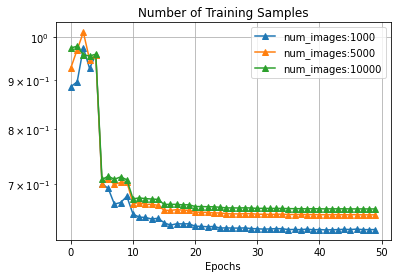

In [ ]:
# this block was ran using mirrored data
# doesn't seem to be significant enough to bother with
lst = [1000,5000,10000]
err_lst = []
loss_lst = []

for num in lst:
    print("number of samples: ",num)
    X_train,Y_train,X_test,Y_test = preprocessing(num,100)
    beta_init = np.random.normal(0,beta_standard_dev,100*100)
    loss_hist, err_val, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test)
    err_lst.append(err_val)
    plt.plot(loss_hist,"-^",label = f"num_images:{num}")

plt.legend()
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)
plt.title("Number of Training Samples")

In [ ]:
print(sum(attribute[:15000]["Male"]==1))
print(sum(attribute[:15000]["Male"]==-1))
8431/20000

6332
11569


0.42155

Explanation:

As more training samples are added, the loss increases which is to be expected. 
    
The test accuracy increases as more training samples are added, also expected. 
    
It is worth noting that despite and additional 5000 images being added, the difference in accuracy and loss is insignificant. 
    
Hence, conclude that 10k images is sufficient to train the model.

## Varying Image Resolution

resolution:  25
epoch:0 	 Loss:0.730 	 error(train):57.5% 	 error(val):57.6%
epoch:2 	 Loss:0.748 	 error(train):57.3% 	 error(val):57.5%
epoch:4 	 Loss:0.764 	 error(train):57.8% 	 error(val):58.0%
epoch:6 	 Loss:0.697 	 error(train):57.9% 	 error(val):58.0%
epoch:8 	 Loss:0.666 	 error(train):57.8% 	 error(val):58.0%
epoch:10 	 Loss:0.736 	 error(train):57.8% 	 error(val):58.0%
epoch:12 	 Loss:0.681 	 error(train):57.8% 	 error(val):58.0%
epoch:14 	 Loss:0.678 	 error(train):57.9% 	 error(val):58.0%
epoch:16 	 Loss:0.677 	 error(train):57.8% 	 error(val):58.0%
epoch:18 	 Loss:0.761 	 error(train):57.8% 	 error(val):58.0%
epoch:20 	 Loss:0.686 	 error(train):57.9% 	 error(val):58.0%
epoch:22 	 Loss:0.621 	 error(train):57.9% 	 error(val):58.0%
epoch:24 	 Loss:0.674 	 error(train):57.9% 	 error(val):58.0%
epoch:26 	 Loss:0.703 	 error(train):57.9% 	 error(val):58.0%
epoch:28 	 Loss:0.624 	 error(train):57.9% 	 error(val):58.0%
epoch:30 	 Loss:0.622 	 error(train):57.9% 	 error(val):58.

Text(0.5, 1.0, 'Resolution of Training Samples')

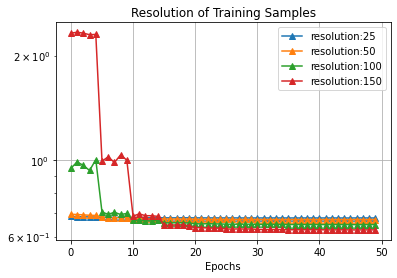

In [ ]:
lst = [25,50,100,150]
err_lst = []
loss_lst = []

for res in lst:
    print("resolution: ",res)
    X_train,Y_train,X_test,Y_test = preprocessing(10000,res)
    beta_standard_dev = 1. / res
    beta_init = np.random.normal(0,beta_standard_dev,res*res)
    loss_hist, err_val, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test)
    err_lst.append(err_val)
    plt.plot(loss_hist,"-^",label = f"resolution:{res}")
    
plt.legend()
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)
plt.title("Resolution of Training Samples")

Explanation:

As the resolution increased, the graphs shows that it took longer to converged. Aside from that issue, there is considerable overfitting with higher resolutions, as seen by the training accuracy increasing and test accuracy decreasing.

To prevent overfitting, we will attempt to increase the learning rate of the samples with resolution 100 and 150 as an experiment.

resolution:  25
epoch:0 	 Loss:0.650 	 error(train):57.7% 	 error(val):57.8%
epoch:2 	 Loss:0.659 	 error(train):57.7% 	 error(val):57.5%
epoch:4 	 Loss:0.668 	 error(train):57.8% 	 error(val):58.0%
epoch:6 	 Loss:0.700 	 error(train):57.3% 	 error(val):57.0%
epoch:8 	 Loss:0.759 	 error(train):57.3% 	 error(val):57.2%
epoch:10 	 Loss:0.725 	 error(train):57.9% 	 error(val):57.5%
epoch:12 	 Loss:0.722 	 error(train):57.8% 	 error(val):58.0%
epoch:14 	 Loss:0.744 	 error(train):57.8% 	 error(val):58.0%
epoch:16 	 Loss:0.719 	 error(train):57.8% 	 error(val):57.9%
epoch:18 	 Loss:0.651 	 error(train):57.8% 	 error(val):58.0%
epoch:20 	 Loss:0.672 	 error(train):57.8% 	 error(val):58.0%
epoch:22 	 Loss:0.676 	 error(train):57.9% 	 error(val):58.0%
epoch:24 	 Loss:0.676 	 error(train):57.8% 	 error(val):58.0%
epoch:26 	 Loss:0.647 	 error(train):57.8% 	 error(val):58.0%
epoch:28 	 Loss:0.667 	 error(train):57.8% 	 error(val):58.0%
epoch:30 	 Loss:0.721 	 error(train):57.8% 	 error(val):58.

Text(0.5, 1.0, 'Resolution of Training Samples')

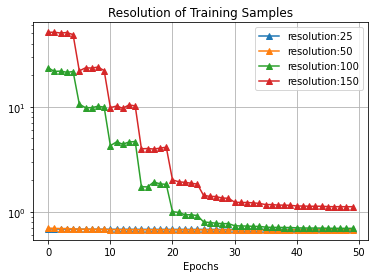

In [ ]:
lst = [25,50,75,100,125,150]
err_lst = []
loss_lst = []
for res in lst:
    if res == 100 or res == 150:
        learning_rate = 0.2
    else:
        learning_rate = 0.01
    print("resolution: ",res)
    X_train,Y_train,X_test,Y_test = preprocessing(10000,res)
    beta_standard_dev = 1. / res
    beta_init = np.random.normal(0,beta_standard_dev,res*res)
    loss_hist, err_val, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test,learning_rate_init = learning_rate)
    err_lst.append(err_val)
    plt.plot(loss_hist,"-^",label = f"resolution:{res}")
plt.legend()
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)
plt.title("Resolution of Training Samples")

Explanation:

Once again, we see that despite increasing learning rate, it did not stop overfitting. Hence, we will go with a 50 by 50 resolution to strike a balance between information loss and overfitting.

## Coloured vs Grayscale

epoch:0 	 Loss:0.747 	 error(train):55.3% 	 error(val):54.9%
epoch:2 	 Loss:0.699 	 error(train):57.9% 	 error(val):56.8%
epoch:4 	 Loss:0.761 	 error(train):58.0% 	 error(val):58.0%
epoch:6 	 Loss:0.783 	 error(train):58.6% 	 error(val):56.6%
epoch:8 	 Loss:0.660 	 error(train):58.8% 	 error(val):55.9%
epoch:10 	 Loss:0.664 	 error(train):57.6% 	 error(val):52.1%
epoch:12 	 Loss:0.652 	 error(train):58.3% 	 error(val):57.8%
epoch:14 	 Loss:0.623 	 error(train):58.3% 	 error(val):57.5%
epoch:16 	 Loss:0.704 	 error(train):58.9% 	 error(val):57.2%
epoch:18 	 Loss:0.644 	 error(train):58.4% 	 error(val):57.6%
epoch:20 	 Loss:0.639 	 error(train):58.5% 	 error(val):57.5%
epoch:22 	 Loss:0.646 	 error(train):58.5% 	 error(val):57.5%
epoch:24 	 Loss:0.646 	 error(train):58.1% 	 error(val):58.1%
epoch:26 	 Loss:0.723 	 error(train):58.5% 	 error(val):57.5%
epoch:28 	 Loss:0.604 	 error(train):59.0% 	 error(val):56.9%
epoch:30 	 Loss:0.711 	 error(train):58.9% 	 error(val):57.4%
epoch:32 	 Lo

Text(0.5, 1.0, 'RGB vs Grayscale')

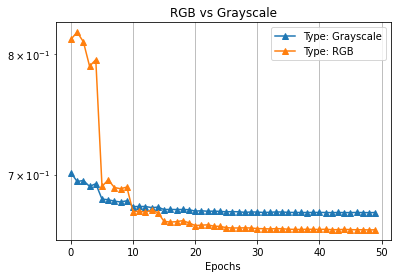

In [ ]:
res = 50
size = 10000
err_lst = []
beta_standard_dev = 1. / res
beta_init = np.random.normal(0,beta_standard_dev,res*res)
X_train,Y_train,X_test,Y_test = preprocessing(size,res)
loss_hist, err_val, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test)
plt.plot(loss_hist,"-^",label = "Type: Grayscale")
err_lst.append(err_val)

beta_init = np.random.normal(0,beta_standard_dev,res*3*res)
X_train,Y_train,X_test,Y_test = preprocessing_RGB(size,res)
loss_hist, err_val, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test)
plt.plot(loss_hist,"-^",label = "Type: RGB")
err_lst.append(err_val)
plt.legend()
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)
plt.title("RGB vs Grayscale")

Explanation:

The increased number of features caused the model to overfit, similar to the increase in dimensions. The model did not improve despite adding RGB hence, we conclude that the grayscale image will suffice in model prediction.

## Adjusting Contrast

epoch:0 	 Loss:0.719 	 error(train):57.8% 	 error(val):58.0%
epoch:2 	 Loss:0.663 	 error(train):57.9% 	 error(val):58.0%
epoch:4 	 Loss:0.678 	 error(train):57.5% 	 error(val):56.0%
epoch:6 	 Loss:0.701 	 error(train):58.1% 	 error(val):58.0%
epoch:8 	 Loss:0.653 	 error(train):58.0% 	 error(val):58.0%
epoch:10 	 Loss:0.689 	 error(train):58.6% 	 error(val):56.2%
epoch:12 	 Loss:0.709 	 error(train):57.9% 	 error(val):58.0%
epoch:14 	 Loss:0.602 	 error(train):58.1% 	 error(val):58.1%
epoch:16 	 Loss:0.661 	 error(train):58.4% 	 error(val):57.9%
epoch:18 	 Loss:0.554 	 error(train):58.0% 	 error(val):58.1%
epoch:20 	 Loss:0.678 	 error(train):58.5% 	 error(val):57.8%
epoch:22 	 Loss:0.643 	 error(train):59.1% 	 error(val):56.6%
epoch:24 	 Loss:0.660 	 error(train):58.7% 	 error(val):57.8%
epoch:26 	 Loss:0.662 	 error(train):58.7% 	 error(val):57.8%
epoch:28 	 Loss:0.656 	 error(train):58.4% 	 error(val):57.8%
epoch:30 	 Loss:0.674 	 error(train):58.5% 	 error(val):57.7%
epoch:32 	 Lo

Text(0.5, 1.0, 'Normal vs High Contrast')

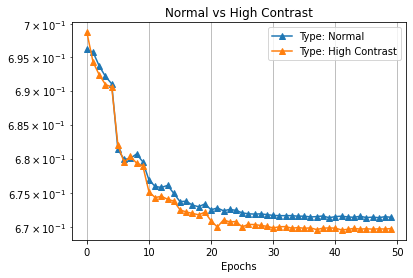

In [ ]:
res = 50
size = 10000
err_lst = []
beta_standard_dev = 1. / res
beta_init = np.random.normal(0,beta_standard_dev,res*res)
X_train,Y_train,X_test,Y_test = preprocessing(size,res)
loss_hist, err_val, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test)
plt.plot(loss_hist,"-^",label = "Type: Normal")
err_lst.append(err_val)

X_train,Y_train,X_test,Y_test = preprocessing(size,res,contrast = True)
loss_hist, err_val, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test)
plt.plot(loss_hist,"-^",label = "Type: High Contrast")
err_lst.append(err_val)

plt.legend()
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)
plt.title("Normal vs High Contrast")

Explanation:
    
High contrast enables better edge detection in our model. Hence, it is beneficial to continue using it. Both models have rather comparable performance in this case.

## Comparing Whole Face against Parts

epoch:0 	 Loss:0.746 	 error(train):44.4% 	 error(val):43.9%
epoch:2 	 Loss:0.620 	 error(train):57.9% 	 error(val):58.0%
epoch:4 	 Loss:0.580 	 error(train):57.8% 	 error(val):58.0%
epoch:6 	 Loss:0.712 	 error(train):51.9% 	 error(val):47.5%
epoch:8 	 Loss:0.720 	 error(train):58.7% 	 error(val):57.5%
epoch:10 	 Loss:0.547 	 error(train):58.0% 	 error(val):58.0%
epoch:12 	 Loss:0.695 	 error(train):58.6% 	 error(val):57.7%
epoch:14 	 Loss:0.731 	 error(train):58.0% 	 error(val):58.0%
epoch:16 	 Loss:0.714 	 error(train):58.3% 	 error(val):58.0%
epoch:18 	 Loss:0.696 	 error(train):59.0% 	 error(val):56.0%
epoch:20 	 Loss:0.645 	 error(train):59.1% 	 error(val):56.0%
epoch:22 	 Loss:0.616 	 error(train):58.6% 	 error(val):57.8%
epoch:24 	 Loss:0.650 	 error(train):59.2% 	 error(val):56.6%
epoch:26 	 Loss:0.635 	 error(train):58.9% 	 error(val):57.6%
epoch:28 	 Loss:0.704 	 error(train):59.2% 	 error(val):55.4%
epoch:30 	 Loss:0.733 	 error(train):58.9% 	 error(val):57.6%
epoch:32 	 Lo

Text(0.5, 1.0, 'Specific Facial Features')

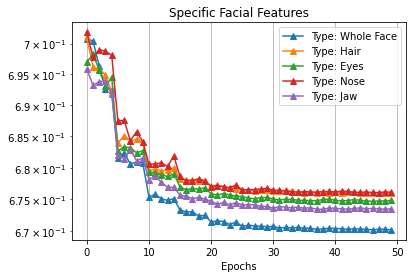

In [ ]:
res = 50
size = 10000
err_lst = []
beta_standard_dev = 1. / res
beta_init = np.random.normal(0,beta_standard_dev,res*res)
X_train,Y_train,X_test,Y_test = preprocessing(size,res,contrast = True)
loss_hist, err_val, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test)
plt.plot(loss_hist,"-^",label = "Type: Whole Face")
err_lst.append(err_val)


X_train_hair,X_train_eyes,X_train_nose,X_train_jaw,Y_train,X_test_hair,X_test_eyes,X_test_nose,X_test_jaw,Y_test = preprocessing_facepart(size,res)
loss_hist, err_val, pred_hair = train_SGD(beta_init,X_train_hair,Y_train,X_test_hair,Y_test)
plt.plot(loss_hist,"-^",label = "Type: Hair")
err_lst.append(err_val)

loss_hist, err_val, pred_eyes = train_SGD(beta_init,X_train_eyes,Y_train,X_test_eyes,Y_test)
plt.plot(loss_hist,"-^",label = "Type: Eyes")
err_lst.append(err_val)

loss_hist, err_val, pred_nose = train_SGD(beta_init,X_train_nose,Y_train,X_test_nose,Y_test)
plt.plot(loss_hist,"-^",label = "Type: Nose")
err_lst.append(err_val)

loss_hist, err_val, pred_Jaw = train_SGD(beta_init,X_train_jaw,Y_train,X_test_jaw,Y_test)
plt.plot(loss_hist,"-^",label = "Type: Jaw")
err_lst.append(err_val)

plt.legend()
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)
plt.title("Specific Facial Features")

## Ensembling with above results

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score
confusion_matrix(Y_test,pred)
def aggregate(*pred):
    """
    desc:
    ===
    Takes in arbitrary number of prediction from individual decision trees and output majority class.
    If there is a tie (i.e. 0), break it at random.
    """
    lst = [sum(x) for x in zip(*pred)]
    agg = []
    for i in lst:
        if i == 0:
            n = np.random.uniform(0,1,1)
            if n<0.5:
                agg.append(-1)
            else:
                agg.append(1)
        elif i<0:
            agg.append(-1)
        else:
            agg.append(1)
        
    return agg
pred = aggregate(pred_hair,pred_eyes,pred_nose,pred_Jaw)
acc = accuracy_score(Y_test,pred)
f1 = f1_score(Y_test,pred)
print("Accuracy: ",acc)
print("F1_score: ",f1)
confusion_matrix(Y_test,pred)

Accuracy:  0.579
F1_score:  0.009411764705882354


array([[2885,   16],
       [2089,   10]])

Explanation:

Ensembling in this case, does not fare any better.

# Balancing Data

In [ ]:
X_train,Y_train,X_test,Y_test = preprocessing(10000,100)

In [ ]:
# We have more females than males, thus try rebalancing
print(sum(Y_train))

-1566


In [ ]:
def rebalance(X_array, Y_array): 
    femalesOver = sum(Y_array) * -1
    genderToReduce = -1

    if femalesOver < 0:
        genderToReduce = 1     # if for some reason males > females, we will reduce the number of males

    femalesWhere = np.where(Y_array == genderToReduce)[0]
    indexToDelete = np.random.choice(femalesWhere, size=femalesOver, replace=False)

    new_X_array = np.delete(X_array, indexToDelete, 0)
    new_Y_array = np.delete(Y_array, indexToDelete)
    return new_X_array, new_Y_array

In [ ]:
X_train, Y_train = rebalance(X_train, Y_train)  # do this to balance male and female (num of datapoints will decrease)

In [ ]:
# Extra females removed
print(sum(Y_train))
print(Y_train.shape)

0
(8434,)


learning rate:  0.001
preprocessed
epoch:0 	 Loss:0.689 	 error(train):49.9% 	 error(val):44.7%
epoch:2 	 Loss:0.680 	 error(train):50.8% 	 error(val):47.9%
epoch:4 	 Loss:0.703 	 error(train):50.6% 	 error(val):45.9%
epoch:6 	 Loss:0.743 	 error(train):52.2% 	 error(val):53.2%
epoch:8 	 Loss:0.697 	 error(train):52.2% 	 error(val):54.6%
epoch:10 	 Loss:0.703 	 error(train):52.4% 	 error(val):53.5%
epoch:12 	 Loss:0.716 	 error(train):52.1% 	 error(val):56.0%
epoch:14 	 Loss:0.679 	 error(train):51.6% 	 error(val):48.9%
epoch:16 	 Loss:0.704 	 error(train):52.6% 	 error(val):53.6%
epoch:18 	 Loss:0.702 	 error(train):52.5% 	 error(val):54.3%
epoch:20 	 Loss:0.691 	 error(train):52.6% 	 error(val):54.6%
epoch:22 	 Loss:0.685 	 error(train):52.8% 	 error(val):52.8%
epoch:24 	 Loss:0.668 	 error(train):52.8% 	 error(val):53.9%
epoch:26 	 Loss:0.692 	 error(train):52.6% 	 error(val):53.9%
epoch:28 	 Loss:0.694 	 error(train):52.6% 	 error(val):53.8%
epoch:30 	 Loss:0.716 	 error(train):52.

Text(0.5, 1.0, 'Number of Training Samples')

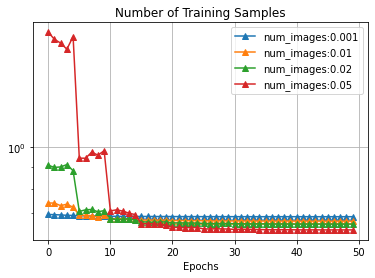

In [ ]:
# balanced   training data
# imbalanced testing data
# varied learning rate to see what it changes

X_train, Y_train = rebalance(X_train, Y_train)

lst = [0.001, 0.01, 0.02, 0.05]
err_lst = []
loss_lst = []

for num in lst:
    print("learning rate: ",num)
    print("preprocessed")
    beta_init = np.random.normal(0,beta_standard_dev,100*100)
    loss_hist, err_val, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test, learning_rate_init = num, regularization=0)
    err_lst.append(err_val)
    plt.plot(loss_hist,"-^",label = f"num_images:{num}")

plt.legend()
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)
plt.title("Number of Training Samples")

learning rate:  0.001
preprocessed
epoch:0 	 Loss:0.697 	 error(train):49.6% 	 error(val):49.0%
epoch:2 	 Loss:0.701 	 error(train):50.8% 	 error(val):49.4%
epoch:4 	 Loss:0.695 	 error(train):50.8% 	 error(val):49.9%
epoch:6 	 Loss:0.725 	 error(train):51.9% 	 error(val):49.5%
epoch:8 	 Loss:0.708 	 error(train):52.1% 	 error(val):49.7%
epoch:10 	 Loss:0.714 	 error(train):52.4% 	 error(val):50.0%
epoch:12 	 Loss:0.692 	 error(train):52.2% 	 error(val):49.8%
epoch:14 	 Loss:0.701 	 error(train):52.5% 	 error(val):50.0%
epoch:16 	 Loss:0.673 	 error(train):52.3% 	 error(val):50.1%
epoch:18 	 Loss:0.677 	 error(train):52.6% 	 error(val):50.0%
epoch:20 	 Loss:0.683 	 error(train):52.5% 	 error(val):50.0%
epoch:22 	 Loss:0.718 	 error(train):52.7% 	 error(val):50.1%
epoch:24 	 Loss:0.700 	 error(train):52.4% 	 error(val):49.7%
epoch:26 	 Loss:0.677 	 error(train):52.6% 	 error(val):50.0%
epoch:28 	 Loss:0.683 	 error(train):52.6% 	 error(val):50.1%
epoch:30 	 Loss:0.699 	 error(train):52.

Text(0.5, 1.0, 'Number of Training Samples')

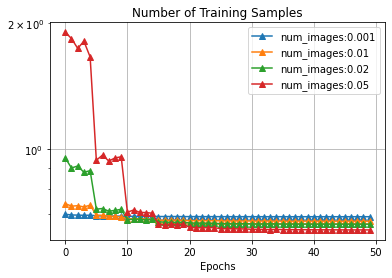

In [ ]:
# balanced training data
# balanced testing data
# varied learning rate to see what it changes

X_train, Y_train = rebalance(X_train, Y_train)
X_test, Y_test = rebalance(X_test, Y_test)

lst = [0.001, 0.01, 0.02, 0.05]
err_lst = []
loss_lst = []

for num in lst:
    print("learning rate: ",num)
    print("preprocessed")
    beta_init = np.random.normal(0,beta_standard_dev,100*100)
    loss_hist, err_val, pred = train_SGD(beta_init,X_train,Y_train,X_test,Y_test, learning_rate_init = num, regularization=0)
    err_lst.append(err_val)
    plt.plot(loss_hist,"-^",label = f"num_images:{num}")

plt.legend()
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)
plt.title("Number of Training Samples")

# Trying stuff (can just delete)


In [ ]:
# maybe SGD sucks and we should just use backtracking on the whole dataset
def train_backtracking_long(beta_init,X_train,Y_train,X_test,Y_test,learning_rate_init = 0.01, regularization = 0, minibatch_size = 20, n_iter = 1000, alpha = 0.5):
    """
    desc:
    ===
    runs SGD with step decay
    
    returns:
    1) Loss at the end of each epoch
    2) Final validation accuracy
    3) Predictions with the given test set
    """

    N = len(X_train)  #10000, total number of images
    img_indices = np.arange(N)
    loss_history = []
    learning_rate_history = []
    beta = np.copy(beta_init)

    for iter in range(n_iter):
        if regularization == 0:
            val, grad = loss_LR_values_and_grad(beta, X_train, Y_train)
        elif regularization == 1:
            val, grad = l1_loss_LR_values_and_grad(beta, X_train, Y_train)
        elif regularization == 2:
            val, grad = l2_loss_LR_values_and_grad(beta, X_train, Y_train)
        
        learning_rate = learning_rate_init
        while loss_LR(beta - (learning_rate*grad), X_train, Y_train ) > (val + alpha*learning_rate*jnp.dot(-grad, grad)):
            learning_rate = 0.5 * learning_rate

        beta = beta - learning_rate*grad
        learning_rate_history.append(learning_rate)
            
        # book-keeping
        loss_history.append(val)
        if iter % 10 == 0:
            # let us compute the train/validation error rate
            err_train = 100*compute_error_rate(beta, X_train, Y_train)
            err_val= 100*compute_error_rate(beta, X_test, Y_test)        
            print(f"iter:{iter} \t Loss:{val:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")

    err_val= 100*compute_error_rate(beta, X_test, Y_test)
    prediction = predict(beta, X_test)
    return loss_history, err_val, pred, learning_rate_history

learning rate:  0.01
iter:0 	 Loss:0.702 	 error(train):49.8% 	 error(val):49.5%
iter:10 	 Loss:0.696 	 error(train):49.9% 	 error(val):49.7%
iter:20 	 Loss:0.694 	 error(train):50.5% 	 error(val):49.8%
iter:30 	 Loss:0.693 	 error(train):50.5% 	 error(val):50.0%
iter:40 	 Loss:0.693 	 error(train):50.6% 	 error(val):49.9%
iter:50 	 Loss:0.692 	 error(train):50.9% 	 error(val):49.7%
iter:60 	 Loss:0.692 	 error(train):51.1% 	 error(val):49.9%
iter:70 	 Loss:0.691 	 error(train):51.4% 	 error(val):50.4%
iter:80 	 Loss:0.691 	 error(train):51.6% 	 error(val):50.5%
iter:90 	 Loss:0.691 	 error(train):51.7% 	 error(val):50.8%


Text(0.5, 1.0, 'Number of Training Samples')

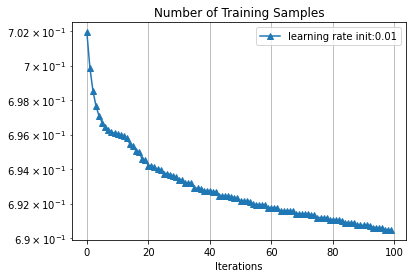

In [ ]:
# balanced training data
# balanced testing data
# wtf why is our model just 50/50ing it i'm gonna try doing backtracking with ALL the data each iteration

X_train, Y_train = rebalance(X_train, Y_train)
X_test, Y_test = rebalance(X_test, Y_test)


lst = [0.01]
err_lst = []
loss_lst = []

for num in lst:
    print("learning rate: ",num)
    beta_init = np.random.normal(0,beta_standard_dev,100*100)
    loss_hist, err_val, pred, learn_rate_hist = train_backtracking_long(beta_init,X_train,Y_train,X_test,Y_test, learning_rate_init = 0.1, regularization=0, n_iter = 00, alpha = 0.5)
    err_lst.append(err_val)
    plt.plot(loss_hist,"-^",label = f"learning rate init:{num}")

plt.legend()
plt.yscale("log")
plt.xlabel("Iterations")
plt.grid(True)
plt.title("Number of Training Samples")

Text(0.5, 0, 'Iterations')

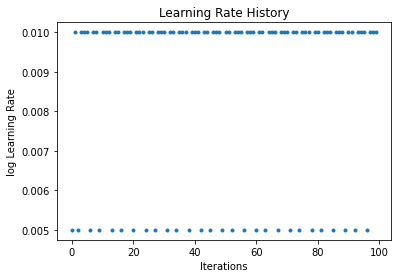

In [ ]:
plt.plot(learn_rate_hist,".")
plt.title("Learning Rate History")
#plt.yscale("log")
plt.ylabel("log Learning Rate")
plt.xlabel("Iterations")